<a href="https://colab.research.google.com/github/Derinhelm/treebank_sentence_length/blob/main/treebank_sent_len.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка датасетов

In [1]:
from IPython.display import clear_output

In [2]:
!wget -m https://github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-train-a.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-train-b.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-train-c.conllu

!wget -m https://github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-dev.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-test.conllu

!mv /content/github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-train-a.conllu /content/ru_syntagrus-ud-train-a.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-train-b.conllu /content/ru_syntagrus-ud-train-b.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-train-c.conllu /content/ru_syntagrus-ud-train-c.conllu

!mv /content/github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-dev.conllu /content/ru_syntagrus-ud-dev.conllu

!mv /content/github.com/UniversalDependencies/UD_Russian-SynTagRus/raw/master/ru_syntagrus-ud-test.conllu /content/ru_syntagrus-ud-test.conllu

clear_output()

In [3]:
!wget -m https://github.com/UniversalDependencies/UD_Russian-Taiga/raw/refs/heads/master/ru_taiga-ud-train.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-Taiga/raw/refs/heads/master/ru_taiga-ud-dev.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-Taiga/raw/refs/heads/master/ru_taiga-ud-test.conllu

!mv /content/github.com/UniversalDependencies/UD_Russian-Taiga/raw/refs/heads/master/ru_taiga-ud-train.conllu /content/ru_taiga-ud-train.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-Taiga/raw/refs/heads/master/ru_taiga-ud-dev.conllu /content/ru_taiga-ud-dev.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-Taiga/raw/refs/heads/master/ru_taiga-ud-test.conllu /content/ru_taiga-ud-test.conllu

clear_output()

In [4]:
!wget -m https://github.com/UniversalDependencies/UD_Russian-Poetry/raw/refs/heads/master/ru_poetry-ud-train.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-Poetry/raw/refs/heads/master/ru_poetry-ud-dev.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-Poetry/raw/refs/heads/master/ru_poetry-ud-test.conllu

!mv /content/github.com/UniversalDependencies/UD_Russian-Poetry/raw/refs/heads/master/ru_poetry-ud-train.conllu /content/ru_poetry-ud-train.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-Poetry/raw/refs/heads/master/ru_poetry-ud-dev.conllu /content/ru_poetry-ud-dev.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-Poetry/raw/refs/heads/master/ru_poetry-ud-test.conllu /content/ru_poetry-ud-test.conllu

clear_output()

In [5]:
!wget -m https://github.com/UniversalDependencies/UD_Russian-GSD/raw/refs/heads/master/ru_gsd-ud-train.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-GSD/raw/refs/heads/master/ru_gsd-ud-dev.conllu
!wget -m https://github.com/UniversalDependencies/UD_Russian-GSD/raw/refs/heads/master/ru_gsd-ud-test.conllu

!mv /content/github.com/UniversalDependencies/UD_Russian-GSD/raw/refs/heads/master/ru_gsd-ud-train.conllu /content/ru_gsd-ud-train.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-GSD/raw/refs/heads/master/ru_gsd-ud-dev.conllu /content/ru_gsd-ud-dev.conllu
!mv /content/github.com/UniversalDependencies/UD_Russian-GSD/raw/refs/heads/master/ru_gsd-ud-test.conllu /content/ru_gsd-ud-test.conllu

clear_output()

# Хранение токенов и предложения



In [6]:
class ConllEntry:
    def __init__(self, id, form, lemma, pos, cpos, feats=None, \
                 parent_id=None, relation=None,deps=None, misc=None):
        self.id = id
        self.form = form
        self.lemma = lemma
        self.pos = pos
        self.cpos = cpos
        self.feats = feats
        self.parent_id = parent_id
        self.relation = relation
        self.deps = deps
        self.misc = misc
        self.root_depth = None

In [7]:
import networkx as nx

class Sentence:
    def __init__(self):
        self.text = ""
        self.sent_id = ""
        self.tokens = []
        self.graph = None


    def add_token(self, token):
        self.tokens.append(token)

    def set_sent_id(self, sent_id):
        self.sent_id = sent_id

    def set_text(self, text):
        self.text = text

    def is_not_empty(self):
        return len(self.tokens) > 0


# Чтение информации из файла

In [8]:

def read_conll(filename):
    fh = open(filename,'r',encoding='utf-8')
    sents_read = 0
    sents = []
    comments = set()

    sent = Sentence()
    for line in fh:
        tok = line.strip().split('\t')
        if not tok or line.strip() == '': # empty line, add sentence to list
            if sent.is_not_empty:
                sents_read += 1
                sents.append(sent)
            sent = Sentence()
        else:
            if line[0] == '#' or '-' in tok[0]: # a comment line
                line = line.strip()
                if line[:12] == "# sent_id = ":
                    sent.set_sent_id(line[12:])
                elif line[:9] == "# text = ":
                    sent.set_text(line[9:])
                else:
                    comments.add(line)

            else: # an actual ConllEntry, add to tokens
                if tok[2] == "_":
                    tok[2] = tok[1].lower()

                token = ConllEntry(*tok)
                sent.add_token(token)
    fh.close()
    return sents

In [9]:
treebank_names = [ "ru_taiga", "ru_poetry", "ru_syntagrus", "ru_gsd"]
sent_types = [ "train", "dev", "test" ]

In [10]:
sents = { t: {} for t in treebank_names}
sents["ru_syntagrus"]["train"] = read_conll("/content/ru_syntagrus-ud-train-a.conllu") + \
                           read_conll("/content/ru_syntagrus-ud-train-b.conllu") + \
                           read_conll("/content/ru_syntagrus-ud-train-c.conllu")
sents["ru_syntagrus"]["dev"] = read_conll("/content/ru_syntagrus-ud-dev.conllu")
sents["ru_syntagrus"]["test"] = read_conll("/content/ru_syntagrus-ud-test.conllu")
for t in treebank_names:
  if t != "ru_syntagrus":
    sents[t]["train"] = read_conll(f"/content/{t}-ud-train.conllu")
    sents[t]["dev"] = read_conll(f"/content/{t}-ud-dev.conllu")
    sents[t]["test"] = read_conll(f"/content/{t}-ud-test.conllu")

In [11]:
len(sents["ru_syntagrus"]['test'])

8800

In [12]:
[(t.id, t.form) for t in sents["ru_syntagrus"]['test'][3946].tokens]

[('1', 'Почему'), ('1.1', '_'), ('2', 'к'), ('3', 'нему'), ('4', '?')]

In [13]:
def delete_point_tokens(s):
  s.tokens = [t for t in s.tokens if "." not in t.id]
  return s

for t in treebank_names:
  for sent_type in sents[t]:
      sents[t][sent_type] = [delete_point_tokens(s) for s in sents[t][sent_type]]

In [14]:
[(t.id, t.form) for t in sents["ru_syntagrus"]['test'][3946].tokens]

[('1', 'Почему'), ('2', 'к'), ('3', 'нему'), ('4', '?')]

In [15]:
for tr in treebank_names:
  tr_sent_type_size = [len(sents[tr][sent_type]) for sent_type in sent_types]
  tr_size = sum(tr_sent_type_size)
  print(tr, tr_size, [round(x / tr_size, 3) for x in tr_sent_type_size])

ru_taiga 17872 [0.898, 0.053, 0.049]
ru_poetry 5086 [0.702, 0.155, 0.143]
ru_syntagrus 87336 [0.797, 0.102, 0.101]
ru_gsd 5030 [0.765, 0.115, 0.119]


# Вычисление статистики по длинам предложений

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
from collections import Counter

In [18]:
import pandas as pd

In [19]:
abs_len_df = pd.DataFrame({ (tr, sent_type): [0]*50 for tr in treebank_names for sent_type in sent_types}, index=list(range(1, 51)))
abs_len_df.columns.names = ['treebank', 'sent_type']
rel_len_df = pd.DataFrame({ (tr, sent_type): [0]*50 for tr in treebank_names for sent_type in sent_types}, index=list(range(1, 51)))
rel_len_df.columns.names = ['treebank', 'sent_type']

for t in treebank_names:
  for sent_type in sents[t]:
      cur_len = Counter(len(s.tokens) for s in sents[t][sent_type])
      abs_len_df[t, sent_type] = [(cur_len[i] if i in cur_len else 0)
                                      for i in abs_len_df.index]
      rel_len_df[t, sent_type] = [(cur_len[i] / cur_len.total() if i in cur_len else 0)
                                      for i in rel_len_df.index]

In [20]:
abs_len_df.head(10)

treebank  ru_taiga          ru_poetry          ru_syntagrus           ru_gsd  \
sent_type    train dev test     train dev test        train  dev test  train   
1               67  49    7       161  50   37            0    0    0      0   
2              568  49   31       166  46   37          583   81   83      2   
3             1413  60   50       162  42   26         1579  205  185      7   
4             1261  79   64       148  36   39         1922  259  184     37   
5             1284  69   59       199  31   28         2270  300  235    109   
6             1322  64   70       188  36   31         2601  357  288    101   
7             1183  49   62       193  30   34         2775  380  342    108   
8             1086  59   60       193  45   28         3027  405  343    133   
9              884  57   42       185  38   32         3084  400  421    174   
10             816  45   46       198  28   32         2946  365  404    170   

treebank            
sent_type dev test  
1           0    0  
2           0    0  
3           2    1  
4           1    6  
5          16   17  
6          15   15  
7           8   26  
8          23   19  
9          26   33  
10         29   29

In [21]:
rel_len_df.head(10).round(4)

treebank  ru_taiga                 ru_poetry                 ru_syntagrus  \
sent_type    train     dev    test     train     dev    test        train   
1           0.0042  0.0518  0.0079    0.0451  0.0634  0.0508       0.0000   
2           0.0354  0.0518  0.0352    0.0465  0.0583  0.0508       0.0084   
3           0.0881  0.0634  0.0568    0.0454  0.0532  0.0357       0.0227   
4           0.0786  0.0835  0.0726    0.0415  0.0456  0.0536       0.0276   
5           0.0800  0.0729  0.0670    0.0558  0.0393  0.0385       0.0326   
6           0.0824  0.0677  0.0795    0.0527  0.0456  0.0426       0.0374   
7           0.0737  0.0518  0.0704    0.0541  0.0380  0.0467       0.0399   
8           0.0677  0.0624  0.0681    0.0541  0.0570  0.0385       0.0435   
9           0.0551  0.0603  0.0477    0.0518  0.0482  0.0440       0.0443   
10          0.0509  0.0476  0.0522    0.0555  0.0355  0.0440       0.0423   

treebank                   ru_gsd                  
sent_type     dev    test   train     dev    test  
1          0.0000  0.0000  0.0000  0.0000  0.0000  
2          0.0091  0.0094  0.0005  0.0000  0.0000  
3          0.0230  0.0210  0.0018  0.0035  0.0017  
4          0.0291  0.0209  0.0096  0.0017  0.0100  
5          0.0337  0.0267  0.0283  0.0276  0.0283  
6          0.0401  0.0327  0.0262  0.0259  0.0250  
7          0.0427  0.0389  0.0281  0.0138  0.0433  
8          0.0455  0.0390  0.0345  0.0397  0.0316  
9          0.0449  0.0478  0.0452  0.0449  0.0549  
10         0.0410  0.0459  0.0442  0.0501  0.0483

In [22]:
for tr in treebank_names:
  print(tr,
        max((rel_len_df[tr]['train'] - rel_len_df[tr]['dev']).round(5).abs()),
        max((rel_len_df[tr]['train'] - rel_len_df[tr]['test']).round(5).abs()),
        max((rel_len_df[tr]['dev'] - rel_len_df[tr]['test']).round(5).abs()))


ru_taiga 0.04762 0.03131 0.04385
ru_poetry 0.01999 0.0173 0.02717
ru_syntagrus 0.00491 0.00669 0.00879
ru_gsd 0.01479 0.01795 0.02944


# Диаграмма Boxplot

In [23]:
len_dict = { t : {} for t in treebank_names }
for t in treebank_names:

  for sent_type in sents[t]:
      len_dict[t][sent_type] = pd.DataFrame([len(s.tokens) for s in sents[t][sent_type]], columns=['sent_len'])


In [24]:
for tr in treebank_names:
    print(tr, sent_type, [len_dict[tr][sent_type].mean().round(1).values[0] for sent_type in sent_types])

ru_taiga test [11.0, 10.7, 11.7]
ru_poetry test [12.3, 12.8, 13.8]
ru_syntagrus test [17.3, 17.2, 17.9]
ru_gsd test [19.5, 20.2, 18.9]


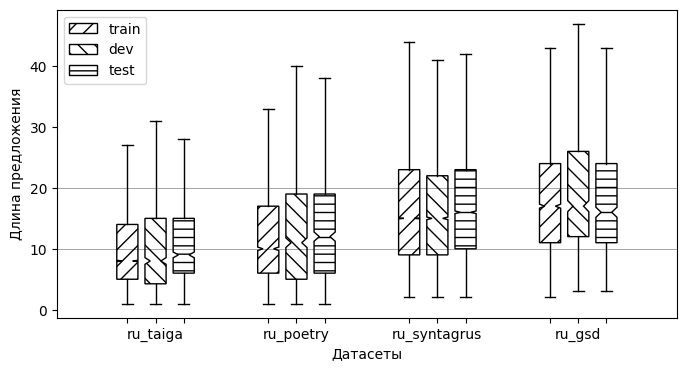

In [25]:
f, axs = plt.subplots(1, 1, figsize=(8, 4))
for tr_i, tr in enumerate(treebank_names):
  box = axs.boxplot(len_dict[tr]['train'].values, positions=[tr_i], showfliers=False,
                    tick_labels=[""], showmeans=False, medianprops={'linewidth':0},
                    patch_artist=True, notch=True, label='train' if tr_i == 0 else "")
  box['boxes'][0].set(hatch = '//')
  box['boxes'][0].set(facecolor = 'white')
  box = axs.boxplot(len_dict[tr]['dev'].values, positions=[tr_i + 0.2], showfliers=False,
              tick_labels=[tr], showmeans=False, medianprops={'linewidth':0},
              patch_artist=True, notch=True, label='dev' if tr_i == 0 else "")
  box['boxes'][0].set(hatch = '\\\\')
  box['boxes'][0].set(facecolor = 'white')
  box = axs.boxplot(len_dict[tr]['test'].values, positions=[tr_i + 0.4], showfliers=False,
              tick_labels=[""], showmeans=False, medianprops={'linewidth':0},
              patch_artist=True, notch=True, label='test' if tr_i == 0 else "")
  box['boxes'][0].set(hatch = '--')
  box['boxes'][0].set(facecolor = 'white')
axs.axhline(10, color='black', alpha=0.5, linewidth=0.5)
axs.axhline(20, color='black', alpha=0.5, linewidth=0.5)
axs.set_ylabel('Длина предложения')
axs.set_xlabel('Датасеты')
axs.legend()

plt.savefig('sentence_length_boxplot.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

# Распределение длин предложений

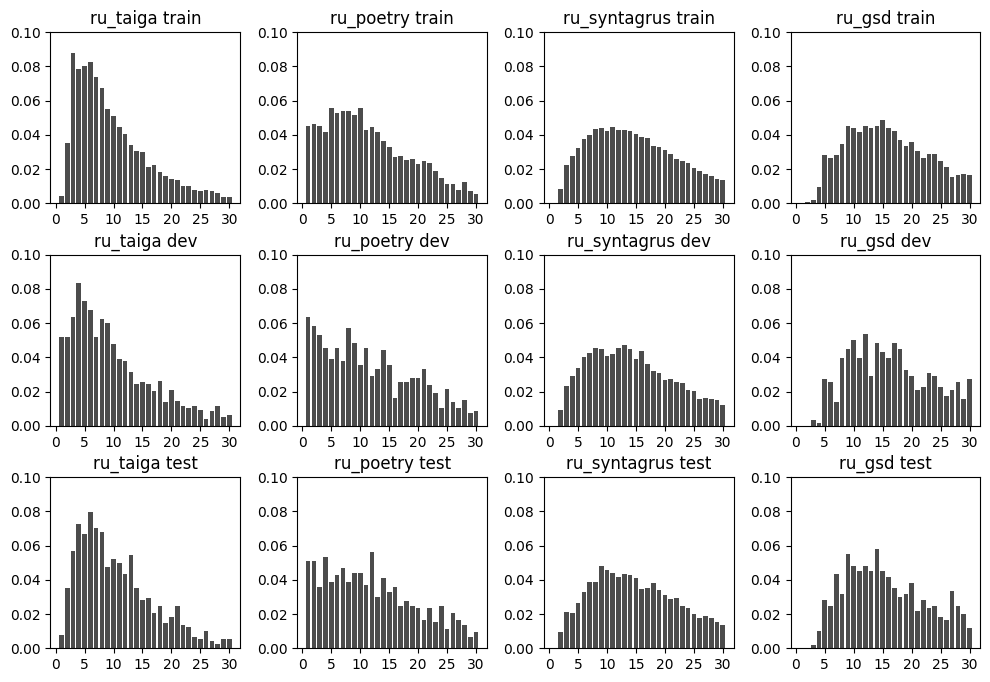

In [26]:
f, axs = plt.subplots(3, 4, figsize=(12, 8))

ax_dict = { 0: axs[0][0], 1: axs[0][1],
            2: axs[1][0], 3: axs[1][1] }
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for tr_i, tr in enumerate(treebank_names):
  for sent_type_i, sent_type in enumerate(sent_types):
    cur_ax = axs[sent_type_i][tr_i]
    cur_ax.bar(rel_len_df.index[:30], rel_len_df[tr][sent_type][:30], label=sent_type,
               facecolor='black', alpha=0.7)#edgecolor='black',)
    cur_ax.set_title(tr + " " + sent_type)
    cur_ax.set_xticks(np.arange(0, 31, step=5))
    cur_ax.set_ylim([0, 0.1])
plt.savefig('sentence_length.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

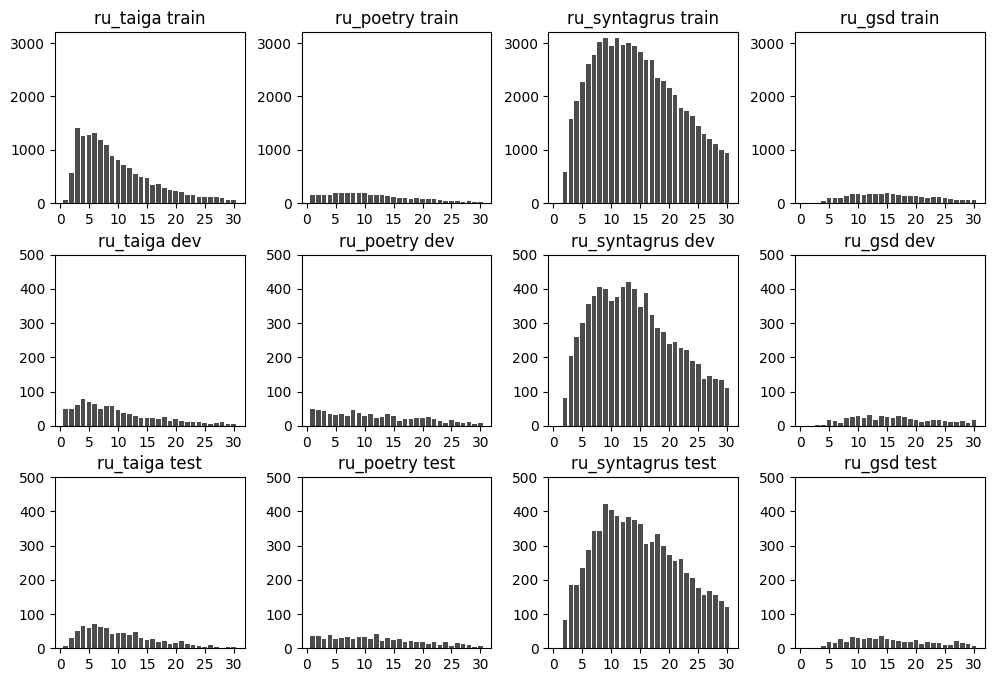

In [27]:
f, axs = plt.subplots(3, 4, figsize=(12, 8))

ax_dict = { 0: axs[0][0], 1: axs[0][1],
            2: axs[1][0], 3: axs[1][1] }
plt.subplots_adjust(wspace=0.3, hspace=0.3)
max_y = [3200, 500, 500]
for tr_i, tr in enumerate(treebank_names):
  for sent_type_i, sent_type in enumerate(sent_types):
    cur_ax = axs[sent_type_i][tr_i]
    cur_ax.bar(abs_len_df.index[:30], abs_len_df[tr][sent_type][:30], label=sent_type,
               facecolor='black', alpha=0.7)#edgecolor='black',)
    cur_ax.set_title(tr + " " + sent_type)
    cur_ax.set_xticks(np.arange(0, 31, step=5))
    cur_ax.set_ylim([0, max_y[sent_type_i]])
plt.savefig('sentence_length.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
abs_len_df.head(10)

treebank  ru_taiga          ru_poetry          ru_syntagrus           ru_gsd  \
sent_type    train dev test     train dev test        train  dev test  train   
1               67  49    7       161  50   37            0    0    0      0   
2              568  49   31       166  46   37          583   81   83      2   
3             1413  60   50       162  42   26         1579  205  185      7   
4             1261  79   64       148  36   39         1922  259  184     37   
5             1284  69   59       199  31   28         2270  300  235    109   
6             1322  64   70       188  36   31         2601  357  288    101   
7             1183  49   62       193  30   34         2775  380  342    108   
8             1086  59   60       193  45   28         3027  405  343    133   
9              884  57   42       185  38   32         3084  400  421    174   
10             816  45   46       198  28   32         2946  365  404    170   

treebank            
sent_type dev test  
1           0    0  
2           0    0  
3           2    1  
4           1    6  
5          16   17  
6          15   15  
7           8   26  
8          23   19  
9          26   33  
10         29   29

In [29]:
rel_len_df.head(10).round(3)

treebank  ru_taiga               ru_poetry               ru_syntagrus         \
sent_type    train    dev   test     train    dev   test        train    dev   
1            0.004  0.052  0.008     0.045  0.063  0.051        0.000  0.000   
2            0.035  0.052  0.035     0.047  0.058  0.051        0.008  0.009   
3            0.088  0.063  0.057     0.045  0.053  0.036        0.023  0.023   
4            0.079  0.084  0.073     0.041  0.046  0.054        0.028  0.029   
5            0.080  0.073  0.067     0.056  0.039  0.038        0.033  0.034   
6            0.082  0.068  0.079     0.053  0.046  0.043        0.037  0.040   
7            0.074  0.052  0.070     0.054  0.038  0.047        0.040  0.043   
8            0.068  0.062  0.068     0.054  0.057  0.038        0.043  0.045   
9            0.055  0.060  0.048     0.052  0.048  0.044        0.044  0.045   
10           0.051  0.048  0.052     0.055  0.035  0.044        0.042  0.041   

treebank         ru_gsd                
sent_type   test  train    dev   test  
1          0.000  0.000  0.000  0.000  
2          0.009  0.001  0.000  0.000  
3          0.021  0.002  0.003  0.002  
4          0.021  0.010  0.002  0.010  
5          0.027  0.028  0.028  0.028  
6          0.033  0.026  0.026  0.025  
7          0.039  0.028  0.014  0.043  
8          0.039  0.035  0.040  0.032  
9          0.048  0.045  0.045  0.055  
10         0.046  0.044  0.050  0.048

In [30]:
abs_len_df.groupby(by=(abs_len_df.index - 1) // 10).sum()

treebank  ru_taiga           ru_poetry           ru_syntagrus              \
sent_type    train  dev test     train  dev test        train   dev  test   
0             9884  580  491      1793  382  324        20787  2752  2485   
1             4362  250  281      1168  245  243        26979  3458  3398   
2             1231   89   81       489  129  115        14185  1729  1855   
3              337   19   15        94   27   30         5312   612   691   
4              123    7    4        15    2    9         1609   222   230   

treebank  ru_gsd            
sent_type  train  dev test  
0            841  120  146  
1           1607  237  251  
2            871  135  134  
3            309   53   46  
4            124   21   13

In [31]:
group_len_dict = { t : {} for t in treebank_names }
for t in treebank_names:
  for sent_type in sents[t]:
    group_len_dict[t][sent_type] = len_dict[t][sent_type].groupby(by=(len_dict[t][sent_type]['sent_len'] - 1) // 10).describe()['sent_len'][['count', 'mean']]
    group_len_dict[t][sent_type]['rate_count'] = group_len_dict[t][sent_type]['count'] / sum(group_len_dict[t][sent_type]['count'])

In [32]:
group_len_dict[t][sent_type]

,count,mean,rate_count
sent_len,,,
0,146.0,7.691781,0.242928
1,251.0,15.111554,0.417637
2,134.0,25.238806,0.222962
3,46.0,34.369565,0.076539
4,13.0,45.538462,0.021631
5,2.0,54.500000,0.003328
6,3.0,66.000000,0.004992
7,3.0,73.666667,0.004992
8,1.0,89.000000,0.001664


In [33]:
pd.concat([
    group_len_dict['ru_syntagrus']['train'],
    group_len_dict['ru_syntagrus']['dev'],
    group_len_dict['ru_syntagrus']['test']
], axis=1).head()

,count,mean,rate_count,count,mean,rate_count,count,mean,rate_count
sent_len,,,,,,,,,
0,20787.0,6.802521,0.298535,2752.0,6.760538,0.309005,2485.0,6.972636,0.282386
1,26979.0,15.176767,0.387462,3458.0,15.066802,0.388278,3398.0,15.203943,0.386136
2,14185.0,24.799789,0.203720,1729.0,24.793522,0.194139,1855.0,24.825876,0.210795
3,5312.0,34.657944,0.076289,612.0,34.828431,0.068718,691.0,34.725036,0.078523
4,1609.0,44.564947,0.023108,222.0,44.738739,0.024927,230.0,44.813043,0.026136


In [34]:
pd.concat([
    group_len_dict['ru_taiga']['train'],
    group_len_dict['ru_taiga']['dev'],
    group_len_dict['ru_taiga']['test']
], axis=1).head()

,count,mean,rate_count,count,mean,rate_count,count,mean,rate_count
sent_len,,,,,,,,,
0,9884.0,5.860279,0.616017,580.0,5.431034,0.613108,491.0,5.991853,0.557321
1,4362.0,14.481660,0.271860,250.0,14.796000,0.264271,281.0,14.441281,0.318956
2,1231.0,24.502843,0.076722,89.0,24.808989,0.094080,81.0,23.962963,0.091941
3,337.0,34.284866,0.021003,19.0,34.736842,0.020085,15.0,35.533333,0.017026
4,123.0,44.349593,0.007666,7.0,45.428571,0.007400,4.0,43.500000,0.004540


In [35]:
pd.concat([
    group_len_dict['ru_poetry']['train'],
    group_len_dict['ru_poetry']['dev'],
    group_len_dict['ru_poetry']['test']
], axis=1).head()

,count,mean,rate_count,count,mean,rate_count,count,mean,rate_count
sent_len,,,,,,,,,
0,1793.0,5.707752,0.502382,382.0,5.170157,0.484157,324.0,5.373457,0.445055
1,1168.0,14.857877,0.327263,245.0,15.044898,0.310520,243.0,14.893004,0.333791
2,489.0,24.235174,0.137013,129.0,24.403101,0.163498,115.0,24.869565,0.157967
3,94.0,34.340426,0.026338,27.0,34.333333,0.034221,30.0,33.600000,0.041209
4,15.0,44.733333,0.004203,2.0,44.000000,0.002535,9.0,44.666667,0.012363


In [36]:
pd.concat([
    group_len_dict['ru_gsd']['train'],
    group_len_dict['ru_gsd']['dev'],
    group_len_dict['ru_gsd']['test']
], axis=1).head()

,count,mean,rate_count,count,mean,rate_count,count,mean,rate_count
sent_len,,,,,,,,,
0,841.0,7.621879,0.218442,120.0,7.866667,0.207254,146.0,7.691781,0.242928
1,1607.0,15.279403,0.417403,237.0,15.299578,0.409326,251.0,15.111554,0.417637
2,871.0,24.831228,0.226234,135.0,25.407407,0.233161,134.0,25.238806,0.222962
3,309.0,34.572816,0.080260,53.0,34.641509,0.091537,46.0,34.369565,0.076539
4,124.0,44.427419,0.032208,21.0,43.857143,0.036269,13.0,45.538462,0.021631


# Статистика по группам предложений

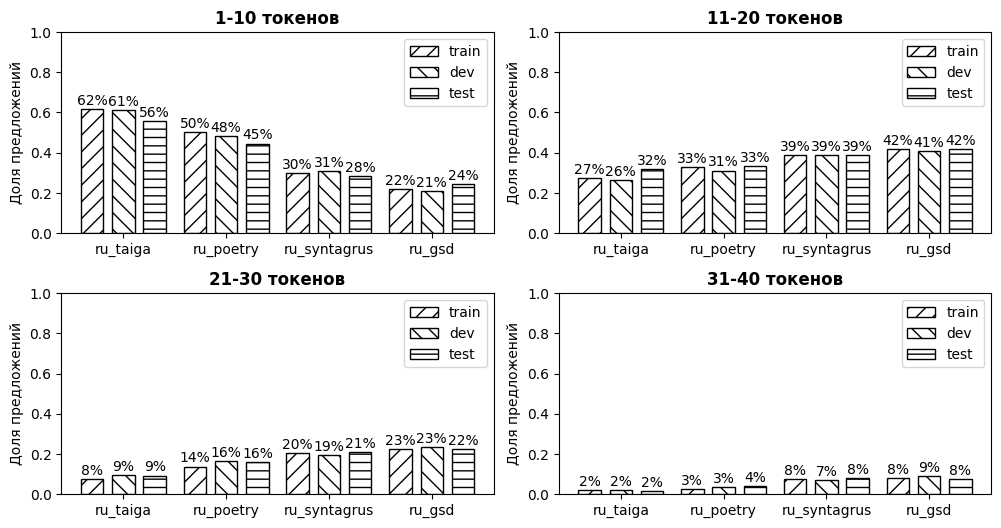

In [37]:
f, axs = plt.subplots(2, 2, figsize=(12, 6))

ax_dict = { 0: axs[0][0], 1: axs[0][1],
            2: axs[1][0], 3: axs[1][1] }
plt.subplots_adjust(wspace=0.15, hspace=0.3)
for i in range(4):
    x_array = np.array([0.0, 0.7, 1.4])
    cur_ax = ax_dict[i]
    for tr_i, tr in enumerate(treebank_names[:4]):
        rects = cur_ax.bar(x_array, [group_len_dict[tr][sent_type]['rate_count'][i] for sent_type in sent_types],
                        0.5, label=sent_types, hatch=['//', '\\\\', '--'],
                        facecolor='w', edgecolor='black',)
        cur_ax.bar_label(rects, padding=1,
                      fmt=lambda x: f"{x * 100:.0f}%")
        x_array += 2.3
        if tr_i == 0:
          cur_ax.legend(loc='upper right')
    cur_ax.set_ylim([0, 1.0])
    #cur_ax.axhline(0.2, color='black', alpha=0.5)
    #cur_ax.axhline(0.4, color='black', alpha=0.5)
    cur_ax.set_xticks([0.7, 3.0, 5.3, 7.6], labels=treebank_names[:4])
    cur_ax.set_ylabel('Доля предложений')
axs[0][0].set_title(f"1-10 токенов", fontdict={'fontweight': 'bold'})
axs[0][1].set_title(f"11-20 токенов", fontdict={'fontweight': 'bold'})
axs[1][0].set_title(f"21-30 токенов", fontdict={'fontweight': 'bold'})
axs[1][1].set_title(f"31-40 токенов", fontdict={'fontweight': 'bold'})

plt.savefig('group_sentence_length.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()